# APS - Mineração de Dados

## Descrição

A ideia do projeto é realizar mineração em textos em resumos de artigos da área de conehcimento Ciências da Computação, identificar os principais tópicos e analisar a evolução temporal, buscando entende como as áreas se relacionam entre si.

### Dados

- Os dados utilizados são da API do Arxv que é um site onde existe um repositório de artigos cientifícos. 
- Serão utilziados dados da área de conhecimento da computação, foram escolhidas 3 subcategorias, Inteligência Artificial, Information Retrival e Machine Learning. 
- Os dados disponíveis na API estão tabulados, e as colunas são: ID, Updated, Published, Title, Summary, Authors, Categories.


### Modelo

- O modelo utilizado para modelagem de tópicos é o modelo de neural BERTopic.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import random

# NLP
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


#BERTopic
from bertopic import BERTopic

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
spacy.cli.download("en_core_web_sm")

In [10]:
# Carrega os dataset que serão utilizados, e cria um com todas as categorias juntas
df_AI = pd.read_csv('data/cs.AI.csv').sample(1500)
df_ML = pd.read_csv('data/cs.LG.csv').sample(1500)
df_IR = pd.read_csv('data/cs.IR.csv').sample(1500)

df_todos = pd.concat([df_AI, df_ML, df_IR], axis=0)

# Converte a coluna Published para datetime
df_AI['Published'] = pd.to_datetime(df_AI['Published'])
df_ML['Published'] = pd.to_datetime(df_ML['Published'])
df_IR['Published'] = pd.to_datetime(df_IR['Published'])
df_todos['Published'] = pd.to_datetime(df_todos['Published'])

# Cria lista com os timestamps e abstracts de cada dataset
ai_timestamps = df_AI.Published.to_list()
ml_timestamps = df_ML.Published.to_list()
ir_timestamps = df_IR.Published.to_list()
todos_timestamps = df_todos.Published.to_list()

ai_abstract = df_AI.Summary.to_list()
ml_abstract = df_ML.Summary.to_list()
ir_abstract = df_IR.Summary.to_list()
todos_abstract = df_todos.Summary.to_list()

ValueError: time data "2011-05-27T01:44:57Z" doesn't match format "%d/%m/%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [5]:
# Apresentação dos dados
def show_data_info(data: pd.DataFrame):
    print(f"Shape: {data.shape}")
    print(f"Columns: {data.columns.values}")
    print("Sample:")
    display(data.head())

show_data_info(df_todos)

Shape: (4500, 7)
Columns: ['ID' 'Updated' 'Published' 'Title' 'Summary' 'Authors' 'Categories']
Sample:


,ID,Updated,Published,Title,Summary,Authors,Categories
3811,http://arxiv.org/abs/1802.07740v2,2018-03-12T21:37:03Z,2018-02-21T19:00:10Z,Machine Theory of Mind,"Theory of mind (ToM; Premack & Woodruff, 197...","Neil C. Rabinowitz, Frank Perbet, H. Francis S...",cs.AI
6400,http://arxiv.org/abs/2101.04017v5,2021-06-02T11:10:56Z,2021-01-11T16:44:38Z,A Commonsense Reasoning Framework for Explanat...,We present DEGARI (Dynamic Emotion Generator...,"Antonio Lieto, Gian Luca Pozzato, Stefano Zoia...","cs.AI, I.2; I.2.1; I.2.3; I.2.4"
7607,http://arxiv.org/abs/2205.06259v1,2022-05-12T17:57:09Z,2022-05-12T17:57:09Z,Computing Programs for Generalized Planning as...,Although heuristic search is one of the most...,"Javier Segovia-Aguas, Sergio Jiménez, Anders J...",cs.AI
3233,http://arxiv.org/abs/1601.04105v1,2016-01-16T00:55:25Z,2016-01-16T00:55:25Z,Learning the Semantics of Structured Data Sources,Information sources such as relational datab...,"Mohsen Taheriyan, Craig A. Knoblock, Pedro Sze...",cs.AI
6234,http://arxiv.org/abs/2011.06780v3,2021-04-13T13:55:31Z,2020-11-13T06:35:17Z,A differential evolution-based optimization to...,The extremely sensitive and highly nonlinear...,"Mingcheng Zuo, Guangming Dai, Lei Peng, Zhe Tang",cs.AI


## Média de Palavras

In [7]:
df_todos['length'] = df_todos.Summary.apply(lambda row: len(row.split()))
print('Mean length: ', df_todos['length'].mean())

Mean length:  160.6822222222222


<Axes: xlabel='length', ylabel='Density'>

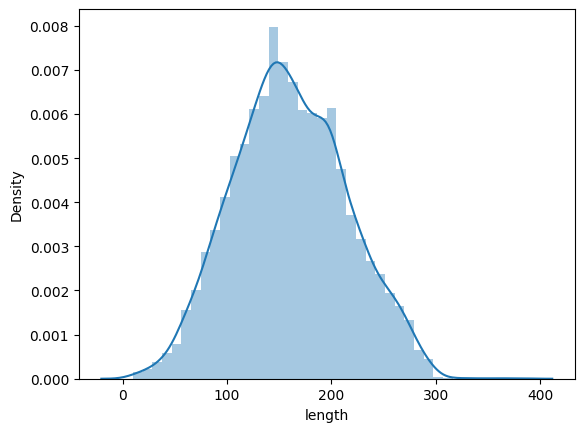

In [10]:
sns.distplot(df_todos['length'])

## Frequência e Nuvem de Palavras 

In [21]:
# Normalização dos dados (remoção de stopwords, pontuação, etc)
def normalize_text(text: str):
    stopword_list = nltk.corpus.stopwords.words('english')
    return  " ".join([word for word in word_tokenize(text.lower()) if word not in stopword_list and word.isalpha()])


# Geração de coluna normalizada com base em outra coluna
def generate_normalized_column(data: pd.DataFrame, from_column: str):
    new_column_name = f"{from_column}_Normalized"
    print(f"New column name: {new_column_name}")
    data[new_column_name] = data.apply(lambda linha: normalize_text(str(linha[from_column])), axis = 1)
    return new_column_name


normalized_summary_column_name = generate_normalized_column(data=df_todos, from_column="Summary")
normalized_summary_column_name = generate_normalized_column(data=df_AI, from_column="Summary")
# normalized_summary_column_name = generate_normalized_column(data=df_IR, from_column="Summary")

New column name: Summary_Normalized
New column name: Summary_Normalized


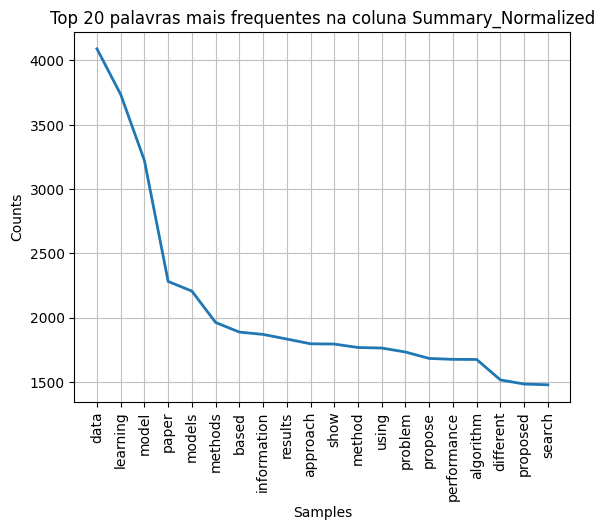

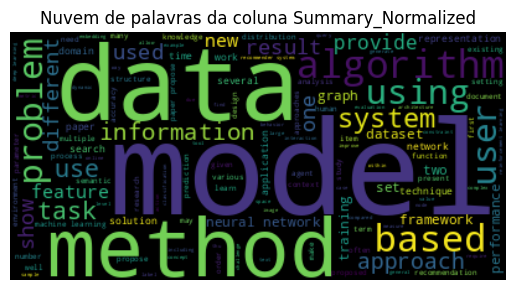

In [22]:
# Geração do histograma de frequência de palavras
def plot_word_frequency_histogram_and_wordcloud(data: pd.DataFrame, column: str, top: int):
    column_data = " ".join(data[column])

    # Histograma
    fdist = FreqDist(column_data.split(" "))
    fdist.plot(top, title=f"Top {top} palavras mais frequentes na coluna {column}")

    # Wordcloud
    wordcloud = WordCloud().generate(column_data)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nuvem de palavras da coluna {column}")
    plt.axis("off")
    plt.show()

plot_word_frequency_histogram_and_wordcloud(data=df_todos, column=normalized_summary_column_name, top=20)

## BERTopic

In [11]:
stopwords = stopwords.words('english') 
vec_model = CountVectorizer(stop_words= stopwords)

In [12]:
topic_model = BERTopic(embedding_model='all-MiniLM-L6-v2', 
                       verbose=True,
                       vectorizer_model = vec_model,
                       low_memory=True,
                       calculate_probabilities=True,
                       n_gram_range=(1, 3))


topics, probs = topic_model.fit_transform(df_todos['Summary'])

2024-06-16 19:20:44,660 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 141/141 [04:03<00:00,  1.72s/it]
2024-06-16 19:24:50,238 - BERTopic - Embedding - Completed ✓
2024-06-16 19:24:50,243 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-16 19:25:15,724 - BERTopic - Dimensionality - Completed ✓
2024-06-16 19:25:15,725 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-16 19:25:16,308 - BERTopic - Cluster - Completed ✓
2024-06-16 19:25:16,317 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-16 19:25:16,867 - BERTopic - Representation - Completed ✓


In [14]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1481,-1_learning_model_data_user,"[learning, model, data, user, based, informati...",[ Modern machine learning models are complex ...
1,0,184,0_policy_rl_reinforcement_reward,"[policy, rl, reinforcement, reward, agent, lea...",[ Learning a reward function from human prefe...
2,1,146,1_graph_node_graphs_gnns,"[graph, node, graphs, gnns, gnn, nodes, networ...",[ We propose a generalization of transformer ...
3,2,135,2_ai_intelligence_artificial_human,"[ai, intelligence, artificial, human, cognitiv...","[ Currently, potential threats of artificial ..."
4,3,121,3_web_search_query_pages,"[web, search, query, pages, page, information,...",[ The majority of Semantic Web search engines...
5,4,98,4_bayesian_belief_inference_networks,"[bayesian, belief, inference, networks, probab...",[ The analysis of practical probabilistic mod...
6,5,92,5_series_time_forecasting_data,"[series, time, forecasting, data, prediction, ...",[ Time series shapelets are discriminative su...
7,6,86,6_clinical_patients_medical_health,"[clinical, patients, medical, health, patient,...",[ The application of Transformer neural netwo...
8,7,84,7_constraint_sat_constraints_solvers,"[constraint, sat, constraints, solvers, proble...",[ Many different approaches for solving Const...
9,8,80,8_belief_theory_probability_evidence,"[belief, theory, probability, evidence, dempst...",[ The problem of combining beliefs in the Dem...


In [15]:
topic_model.get_topic(-1)

[('learning', 0.008332834145417285),
 ('model', 0.008268058251091212),
 ('data', 0.007876967911548917),
 ('user', 0.007303731933642162),
 ('based', 0.007292046461238193),
 ('information', 0.007124794309289495),
 ('models', 0.006752268555466173),
 ('paper', 0.00644480880063094),
 ('users', 0.006047867987636611),
 ('methods', 0.005905133589053112)]

In [18]:
topic_labels = topic_model.generate_topic_labels(nr_words=3, separator=", ")
topic_labels

['-1, learning, model, data',
 '0, policy, rl, reinforcement',
 '1, graph, node, graphs',
 '2, ai, intelligence, artificial',
 '3, web, search, query',
 '4, bayesian, belief, inference',
 '5, series, time, forecasting',
 '6, clinical, patients, medical',
 '7, constraint, sat, constraints',
 '8, belief, theory, probability',
 '9, matrix, kernel, manifold',
 '10, retrieval, document, ranking',
 '11, ontology, ontologies, web',
 '12, news, social, media',
 '13, scientific, papers, articles',
 '14, planning, plan, planners',
 '15, game, games, agents',
 '16, ratings, filtering, collaborative',
 '17, ranking, rank, rankings',
 '18, item, sequential, recommendation',
 '19, label, labels, multi',
 '20, physical, physics, equations',
 '21, classification, classifiers, selection',
 '22, image, retrieval, images',
 '23, networks, neural, network',
 '24, traffic, road, prediction',
 '25, hashing, hash, codes',
 '26, bandit, regret, arm',
 '27, bit, hardware, quantization',
 '28, federated, fl, cl

In [20]:
topic_model.get_document_info(df_todos['Summary'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,This article studies the problem of modifyin...,14,14_planning_plan_planners_plans,"[planning, plan, planners, plans, heuristic, r...",[ Fast Downward is a classical planning syste...,planning - plan - planners - plans - heuristic...,0.100717,False
1,In the context of humans operating with arti...,50,50_agents_agent_team_coordination,"[agents, agent, team, coordination, cooperativ...",[ Zero-shot human-AI coordination holds the p...,agents - agent - team - coordination - coopera...,1.000000,False
2,"In this paper, we study the task of multimod...",75,75_multimodal_modalities_fusion_acoustic,"[multimodal, modalities, fusion, acoustic, phr...","[ As humans, we experience the world with all...",multimodal - modalities - fusion - acoustic - ...,1.000000,True
3,In his seminal book `The Inmates are Running...,2,2_ai_intelligence_artificial_human,"[ai, intelligence, artificial, human, cognitiv...","[ Currently, potential threats of artificial ...",ai - intelligence - artificial - human - cogni...,0.360571,False
4,Sorting by reversals is an important problem...,52,52_mining_frequent_itemsets_rules,"[mining, frequent, itemsets, rules, patterns, ...",[ We study the problem of frequent itemset mi...,mining - frequent - itemsets - rules - pattern...,0.126911,False
...,...,...,...,...,...,...,...,...
4495,Recommender systems provide personalized rec...,16,16_ratings_filtering_collaborative_users,"[ratings, filtering, collaborative, users, rec...",[ Collaborative filtering is the process of m...,ratings - filtering - collaborative - users - ...,0.308893,True
4496,Learning the compatibility between fashion i...,65,65_fashion_outfit_compatibility_items,"[fashion, outfit, compatibility, items, style,...",[ Modelling mix-and-match relationships among...,fashion - outfit - compatibility - items - sty...,0.761318,False
4497,"Using only implicit data, many recommender s...",16,16_ratings_filtering_collaborative_users,"[ratings, filtering, collaborative, users, rec...",[ Collaborative filtering is the process of m...,ratings - filtering - collaborative - users - ...,0.408073,False
4498,"Weibo, as the largest social media service i...",12,12_news_social_media_twitter,"[news, social, media, twitter, sentiment, opin...",[ An important part of the information gather...,news - social - media - twitter - sentiment - ...,0.323051,False


In [33]:
df_result = topic_model.get_topic_info()
df_result['Count'].sum()

4500

In [16]:
topic_model.visualize_topics()

In [31]:
topic_model.visualize_barchart()